## 1. Import library

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from collections import Counter

In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"magrozan","key":"09455255ad91ddcb6d114bd02ad099f9"}'}

In [8]:
import os
import zipfile

# Buat folder .kaggle dan pindahkan file ke sana
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json

# Ubah permission
!chmod 600 /root/.kaggle/kaggle.json


## 2. Load dataset from kaggle

In [9]:
!kaggle datasets download kingabzpro/daylio-mood-tracker

Dataset URL: https://www.kaggle.com/datasets/kingabzpro/daylio-mood-tracker
License(s): copyright-authors


In [10]:
!unzip daylio-mood-tracker.zip

Archive:  daylio-mood-tracker.zip
  inflating: Daylio_Abid.csv         


## 3. Data Loading

In [11]:
dataf = pd.read_csv('Daylio_Abid.csv')
dataf.head()

,full_date,date,weekday,time,sub_mood,activities,mood
0,16/04/2021,Apr-16,Friday,8:00 pm,yolo,reading | Art | prayer | fasting | walk | med...,Good
1,15/04/2021,Apr-15,Thursday,2:37 am,focused,reading | learning | Art | prayer | fasting ...,Good
2,14/04/2021,Apr-14,Wednesday,2:39 am,confused,reading | learning | prayer | fasting | Qura...,Normal
3,13/04/2021,Apr-13,Tuesday,2:38 am,wondering,reading | learning | Art | prayer | fasting ...,Normal
4,12/04/2021,Apr-12,Monday,9:52 pm,angry,reading | learning | fasting | walk | medita...,Awful


## 4. Data understanding

In [12]:
dataf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   full_date   940 non-null    object
 1   date        940 non-null    object
 2   weekday     940 non-null    object
 3   time        940 non-null    object
 4   sub_mood    940 non-null    object
 5   activities  893 non-null    object
 6   mood        940 non-null    object
dtypes: object(7)
memory usage: 51.5+ KB


In [13]:
dataf.shape

(940, 7)

In [14]:
dataf.describe()

,full_date,date,weekday,time,sub_mood,activities,mood
count,940,940,940,940,940,893,940
unique,775,366,7,425,22,839,5
top,07/02/2018,Mar-01,Wednesday,9:00 pm,blessed,Dota 2,Good
freq,4,7,139,65,174,10,487


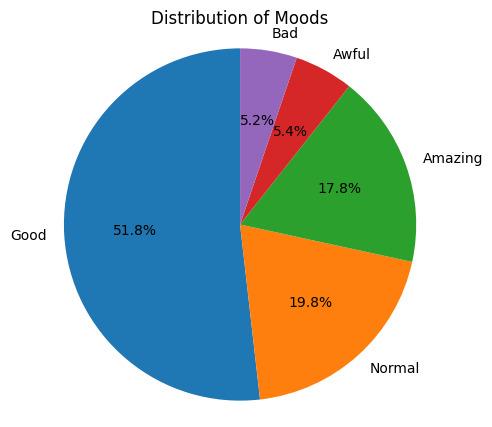

In [55]:
import matplotlib.pyplot as plt

mood_counts = dataf['mood'].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(mood_counts, labels=mood_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Moods')
plt.axis('equal')
plt.show()


In [52]:
activity_counts = Counter()
for activities_str in dataf['activities']:
    try:
        activities = activities_str.split('|')
        for activity in activities:
            activity = activity.strip()
            if activity:
              activity_counts[activity] += 1
    except AttributeError:
        pass
print(activity_counts.most_common())


[('youtube', 770), ('streaming', 710), ('good meal', 586), ('Audio books', 553), ('reddit', 542), ('meditation', 541), ('Watching series', 539), ('walk', 521), ('News Update', 520), ('fasting', 485), ('shower', 431), ('power nap', 400), ('prayer', 398), ('penpal', 388), ('writing', 317), ('language learning', 312), ('songs', 289), ('Dota 2', 284), ('research', 279), ('new things', 277), ('reading', 273), ('Tutorial', 249), ('coding', 244), ('learning', 241), ('Documentary', 232), ('podcast', 225), ('cooking', 215), ('cleaning', 185), ('Art', 182), ('Quran', 160), ('designing', 126), ('love', 123), ('weight log', 120), ('Email', 115), ('keto', 102), ('Write dairy', 83), ('movies', 83), ('family', 66), ('Recording', 61), ('gaming', 55), ('travel', 51), ('repair', 37), ('Exercise', 30), ('shave', 28), ('jobs', 26), ('Poetry', 21), ('yoga', 14), ('holotropic', 13), ('friends', 12), ('trimming', 11), ('kaballah', 11), ('shopping', 8), ('phd', 7), ('party', 6), ('hospital', 4), ('video editi

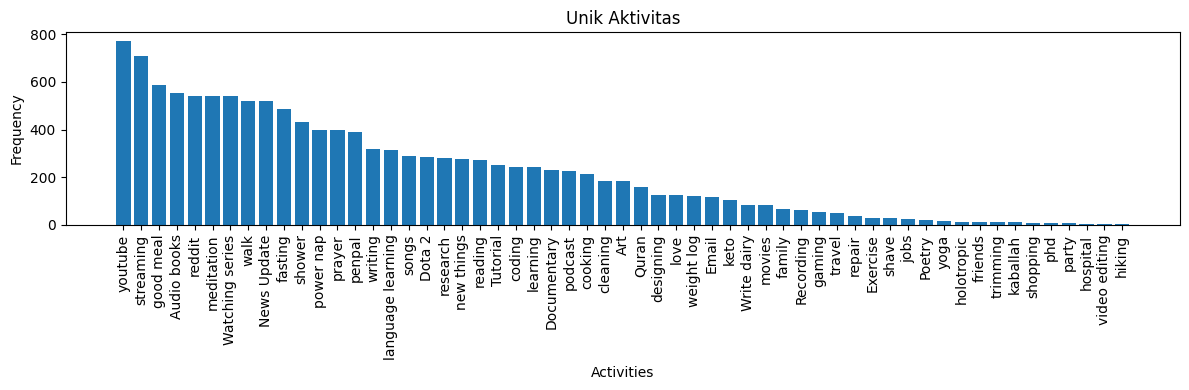

In [57]:
activity_names = [activity[0] for activity in activity_counts.most_common()]
activity_frequencies = [activity[1] for activity in activity_counts.most_common()]

plt.figure(figsize=(12, 4))
plt.bar(activity_names, activity_frequencies)
plt.xlabel("Activities")
plt.ylabel("Frequency")
plt.title("Unik Aktivitas")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 5. Data preparation

In [15]:
#drop tabel yang tidak dibutuhkan
dataf = dataf.drop(['full_date', 'date', 'weekday', 'time', 'sub_mood'], axis=1)

In [16]:
dataf.head()

,activities,mood
0,reading | Art | prayer | fasting | walk | med...,Good
1,reading | learning | Art | prayer | fasting ...,Good
2,reading | learning | prayer | fasting | Qura...,Normal
3,reading | learning | Art | prayer | fasting ...,Normal
4,reading | learning | fasting | walk | medita...,Awful


In [46]:
#ambil data dengan skala good, amazing, normal saja
dataFrame = dataf[dataf['mood'].isin(['Good', 'Amazing', 'Normal'])]

In [47]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 840 entries, 0 to 939
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   activities  799 non-null    object
 1   mood        840 non-null    object
dtypes: object(2)
memory usage: 19.7+ KB


In [18]:
dataFrame.head()

,activities,mood
0,reading | Art | prayer | fasting | walk | med...,Good
1,reading | learning | Art | prayer | fasting ...,Good
2,reading | learning | prayer | fasting | Qura...,Normal
3,reading | learning | Art | prayer | fasting ...,Normal
5,reading | learning | prayer | fasting | walk...,Normal


In [19]:
#cek missing value
dataFrame.isnull().sum()

,0
activities,41
mood,0


In [20]:
dataFrame = dataFrame.dropna()
dataFrame.isnull().sum()


,0
activities,0
mood,0


In [21]:
#tokenisasi
def custom_tokenizer(text):
    tokens = re.split(r'[^a-zA-Z0-9]', text)
    tokens = [token for token in tokens if token.strip() != '']
    return tokens

In [22]:
data = dataFrame
df = pd.DataFrame(data)

In [23]:
df['processed_activities'] = df['activities'].str.replace('|', ' ', regex=False)

In [24]:
df.head()

,activities,mood,processed_activities
0,reading | Art | prayer | fasting | walk | med...,Good,reading Art prayer fasting walk med...
1,reading | learning | Art | prayer | fasting ...,Good,reading learning Art prayer fasting ...
2,reading | learning | prayer | fasting | Qura...,Normal,reading learning prayer fasting Qura...
3,reading | learning | Art | prayer | fasting ...,Normal,reading learning Art prayer fasting ...
5,reading | learning | prayer | fasting | walk...,Normal,reading learning prayer fasting walk...


## 6. Modeling

In [25]:
#ubah ke matrix TF-IDF
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
tfidf_matrix = vectorizer.fit_transform(df['processed_activities'])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [26]:
vectorizer

TfidfVectorizer(tokenizer=<function custom_tokenizer at 0x79dadd312c00>)

In [27]:
#lihat ukuran matrix
tfidf_matrix.shape

(799, 67)

In [28]:
#hitung cosine similar
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.74519702, 0.62974863, ..., 0.11476642, 0.184265  ,
        0.42048442],
       [0.74519702, 1.        , 0.79086985, ..., 0.2295942 , 0.15388007,
        0.27598877],
       [0.62974863, 0.79086985, 1.        , ..., 0.2437595 , 0.16337403,
        0.29301648],
       ...,
       [0.11476642, 0.2295942 , 0.2437595 , ..., 1.        , 0.10311881,
        0.34181165],
       [0.184265  , 0.15388007, 0.16337403, ..., 0.10311881, 1.        ,
        0.        ],
       [0.42048442, 0.27598877, 0.29301648, ..., 0.34181165, 0.        ,
        1.        ]])

In [29]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['activities'], columns=df['activities'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada activities
cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape: (799, 799)


activities,Dota 2 | streaming | cleaning | Email,reading | prayer | fasting | Quran | walk | meditation | Audio books | Watching series | News Update | good meal | reddit | language learning | streaming | youtube | new things | songs | designing | penpal | coding | Tutorial | love,reading | learning | fasting | walk | writing | Watching series | good meal | reddit | language learning | streaming | youtube | cooking | cleaning | research | new things | power nap | songs | designing | Documentary | penpal | coding | Tutorial,Write dairy | walk | meditation | Audio books | good meal | streaming | youtube | new things,learning | Art | prayer | fasting | walk | meditation | shower | Audio books | writing | Watching series | News Update | good meal | reddit | language learning | Poetry | streaming | youtube | cooking | cleaning | research | power nap | songs | Documentary | penpal | coding | Tutorial | jobs,reading | Write dairy | prayer | shower | Audio books | Watching series | new things | Email | weight log,prayer | fasting | Dota 2 | podcast | streaming | youtube | Email | jobs,learning | Art | prayer | fasting | Exercise | Quran | walk | meditation | shower | Dota 2 | podcast | Audio books | Watching series | News Update | good meal | reddit | language learning | streaming | youtube | new things | songs | Tutorial,Art | prayer | walk | meditation | shower | Dota 2 | podcast | Audio books | writing | Watching series | News Update | good meal | reddit | streaming | youtube | power nap | songs | designing | penpal,prayer | fasting | walk | meditation | shower | Dota 2 | Audio books | Watching series | News Update | good meal | reddit | streaming | youtube | power nap | songs | penpal
activities,,,,,,,,,,
reading | shower | good meal | youtube | new things | power nap | weight log,0.000000,0.285518,0.355783,0.310763,0.172464,0.571238,0.026331,0.230541,0.237475,0.279683
learning | fasting | walk | shower | Audio books | Watching series | News Update | good meal | reddit | language learning | yoga | shave | trimming | Poetry | streaming | youtube | cooking | cleaning | research | new things | family | power nap | Email | Documentary | penpal | coding | Tutorial,0.224900,0.424599,0.575443,0.221199,0.619285,0.230609,0.135768,0.391527,0.276586,0.348093
prayer | streaming | youtube | travel | research | new things,0.048204,0.257865,0.265177,0.292741,0.145019,0.236060,0.138053,0.229196,0.111542,0.131368
prayer | shower | podcast | Audio books | News Update | good meal | reddit | streaming | youtube | songs,0.049243,0.441112,0.216176,0.273792,0.390611,0.201891,0.273915,0.524222,0.645219,0.633449
learning | Art | prayer | fasting | walk | meditation | shower | Dota 2 | Audio books | writing | Watching series | News Update | good meal | reddit | language learning | streaming | youtube | cooking | cleaning | research | new things | power nap | songs | Documentary | penpal | coding | Tutorial,0.294201,0.631877,0.810597,0.311143,0.792473,0.236247,0.216458,0.708654,0.648026,0.667385
reading | fasting | shower | podcast | Audio books | writing | Watching series | News Update | good meal | reddit | language learning | streaming | youtube | movies | cooking | research | new things | power nap | songs | Documentary | penpal | coding | Tutorial,0.027235,0.622661,0.776690,0.278312,0.644752,0.273132,0.142633,0.548096,0.513036,0.514416
reading | prayer | fasting | Exercise | walk | meditation | shower | Audio books | writing | Watching series | good meal | reddit | language learning | Poetry | streaming | youtube | movies | cooking | holotropic | travel | cleaning | research | new things | power nap | Documentary | penpal | coding | Tutorial,0.109777,0.462342,0.618877,0.257592,0.641712,0.233624,0.084219,0.498406,0.333068,0.377183
Dota 2,0.598686,0.000000,0.000000,0.000000,0.000000,0.000000,0.425041,0.279018,0.343419,0.404459
prayer | fasting | walk | meditation | shower | podcast | Audio books | writing | Watching series | News Update | good meal | red

In [42]:
def recommend_activities(input_activities, df, cosine_sim,top_n=1):
    input_vector = vectorizer.transform([input_activities])
    input_cosine_sim = cosine_similarity(input_vector, tfidf_matrix)

    sim_scores = list(enumerate(input_cosine_sim[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n + 1]

    activity_indices = [i[0] for i in sim_scores]

    similar_activities_df = df.iloc[activity_indices][['activities']].copy()
    similar_activities_df['activities_list'] = similar_activities_df['activities'].apply(
        lambda x: [activity.strip() for activity in x.split('|')]
    )

    all_activities = [activity for sublist in similar_activities_df['activities_list'] for activity in sublist]
    input_activities_list = [activity.strip() for activity in input_activities.split('|')]
    filtered_activities = [activity for activity in all_activities if activity not in input_activities_list]

    activity_counts = Counter(filtered_activities)
    sorted_activities = sorted(activity_counts.keys(), key=lambda x: activity_counts[x], reverse=True)

    return sorted_activities

In [43]:
score = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix)
score


array([[1.        , 0.74519702, 0.62974863, 0.72457155, 0.79109155,
        0.83704463, 0.84679278, 0.82479792, 0.68282785, 0.66771408,
        0.68262609, 0.64129477, 0.86408004, 0.84102724, 0.84273277,
        0.67930875, 0.67046865, 0.82481574, 0.65329939, 0.82766742,
        0.79807168, 0.76128278, 0.86847393, 0.8368297 , 0.72204176,
        0.7694658 , 0.76453469, 0.72052064, 0.73339535, 0.67935311,
        0.73853048, 0.66537552, 0.74259372, 0.61636963, 0.76457174,
        0.72611841, 0.82302724, 0.693842  , 0.73634888, 0.74516012,
        0.80457702, 0.54676089, 0.76629436, 0.76092186, 0.74097777,
        0.7544539 , 0.5599584 , 0.61254794, 0.70357718, 0.63815535,
        0.74629703, 0.75307901, 0.62734706, 0.75397755, 0.8128032 ,
        0.79830729, 0.73552865, 0.67613679, 0.73817793, 0.67176595,
        0.70045421, 0.66570583, 0.71584806, 0.68387089, 0.68875637,
        0.68309862, 0.64855765, 0.68793374, 0.6033543 , 0.79259598,
        0.69996159, 0.53387373, 0.71491909, 0.64

In [44]:
input_activities = 'fasting'
recommendations = recommend_activities(input_activities, df, cosine_sim)
recommendations

['prayer', 'streaming', 'youtube']